<a href="https://colab.research.google.com/github/whipIash/reCAPTCHASolver/blob/main/reCAPTCHA_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving reCAPTCHAs with transfer learning
In this model, I use transfer learning with the VGG16 model to label reCAPTCHA images. The dataset is from https://github.com/deathlyface/recaptcha-dataset. 

VGG16 is a convolutional neural network model proposed at the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

Using the pre-trained network on images not in the training set is called transfer learning. Here, I use transfer learning to train a network to classify reCAPTCHA images with a 61% accuracy.

Note: I edited out some of the data because it had classes that the VGG16 model was not trained to recognize and therefore would be less effective with. Then, I removed a bit more of the data so that there would be a balanced distribution of around 1000 images per class. This is important so that the model does not guess car every time and get it right half the time because there would be 3000 images of a car.


###Step 1: Declaring the imports 
Additionally, I mounted google drive since I uploaded my dataset to my drive for ease of access.



In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


###Getting the data and splitting into test, train and validation

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

data_dir = '/content/gdrive/My Drive/Datasets/editedDataset'

# augment the data, convert it to a normalized torch.FloatTensor and resize it 
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Get the entire dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Splitting the full dataset into training and testing
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
    num_workers=num_workers, shuffle=True)

# specify the image classes
classes = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Traffic Light']

Visualize the training data

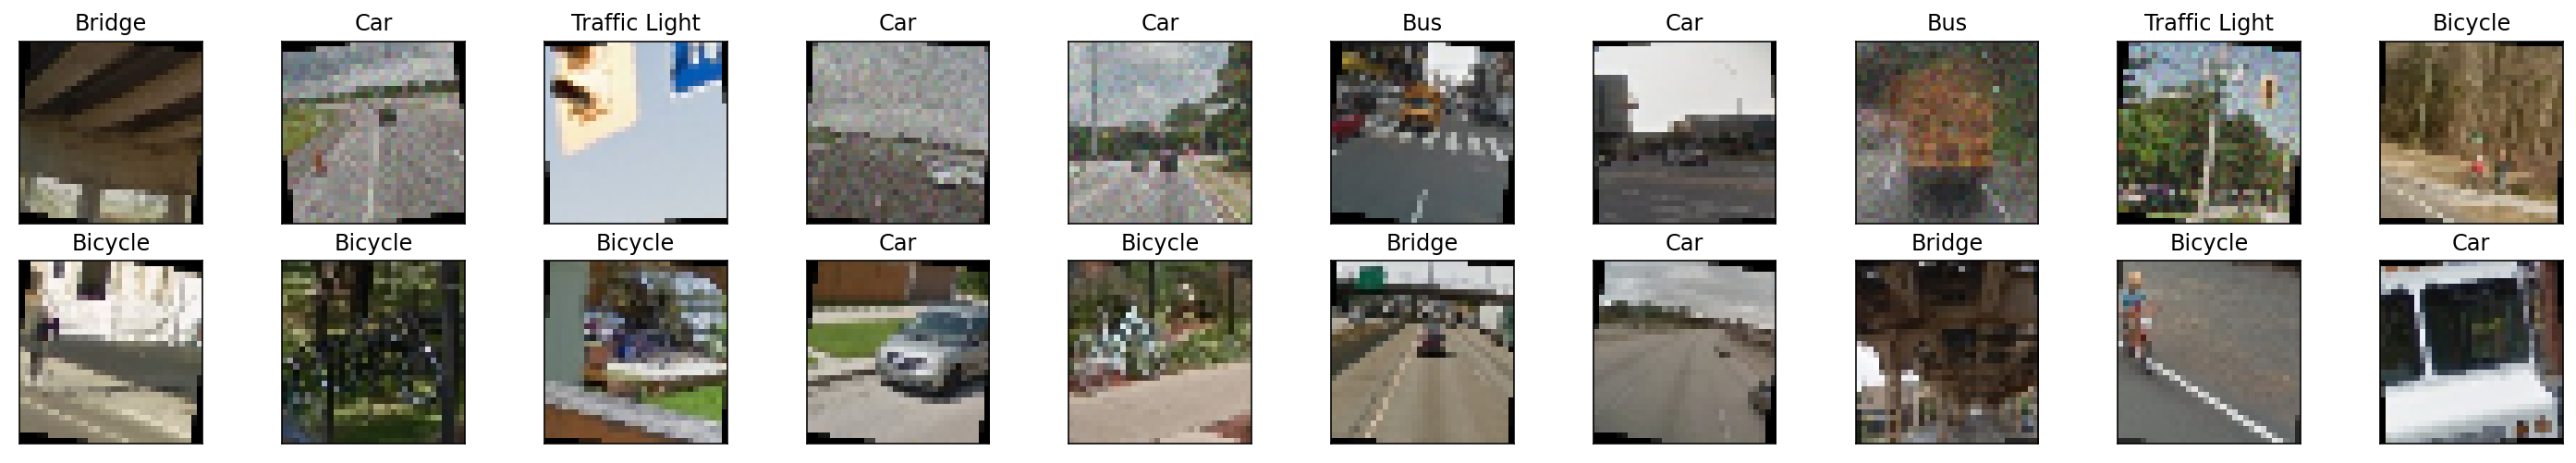

In [ ]:
# function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
  
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

An image in even more detail



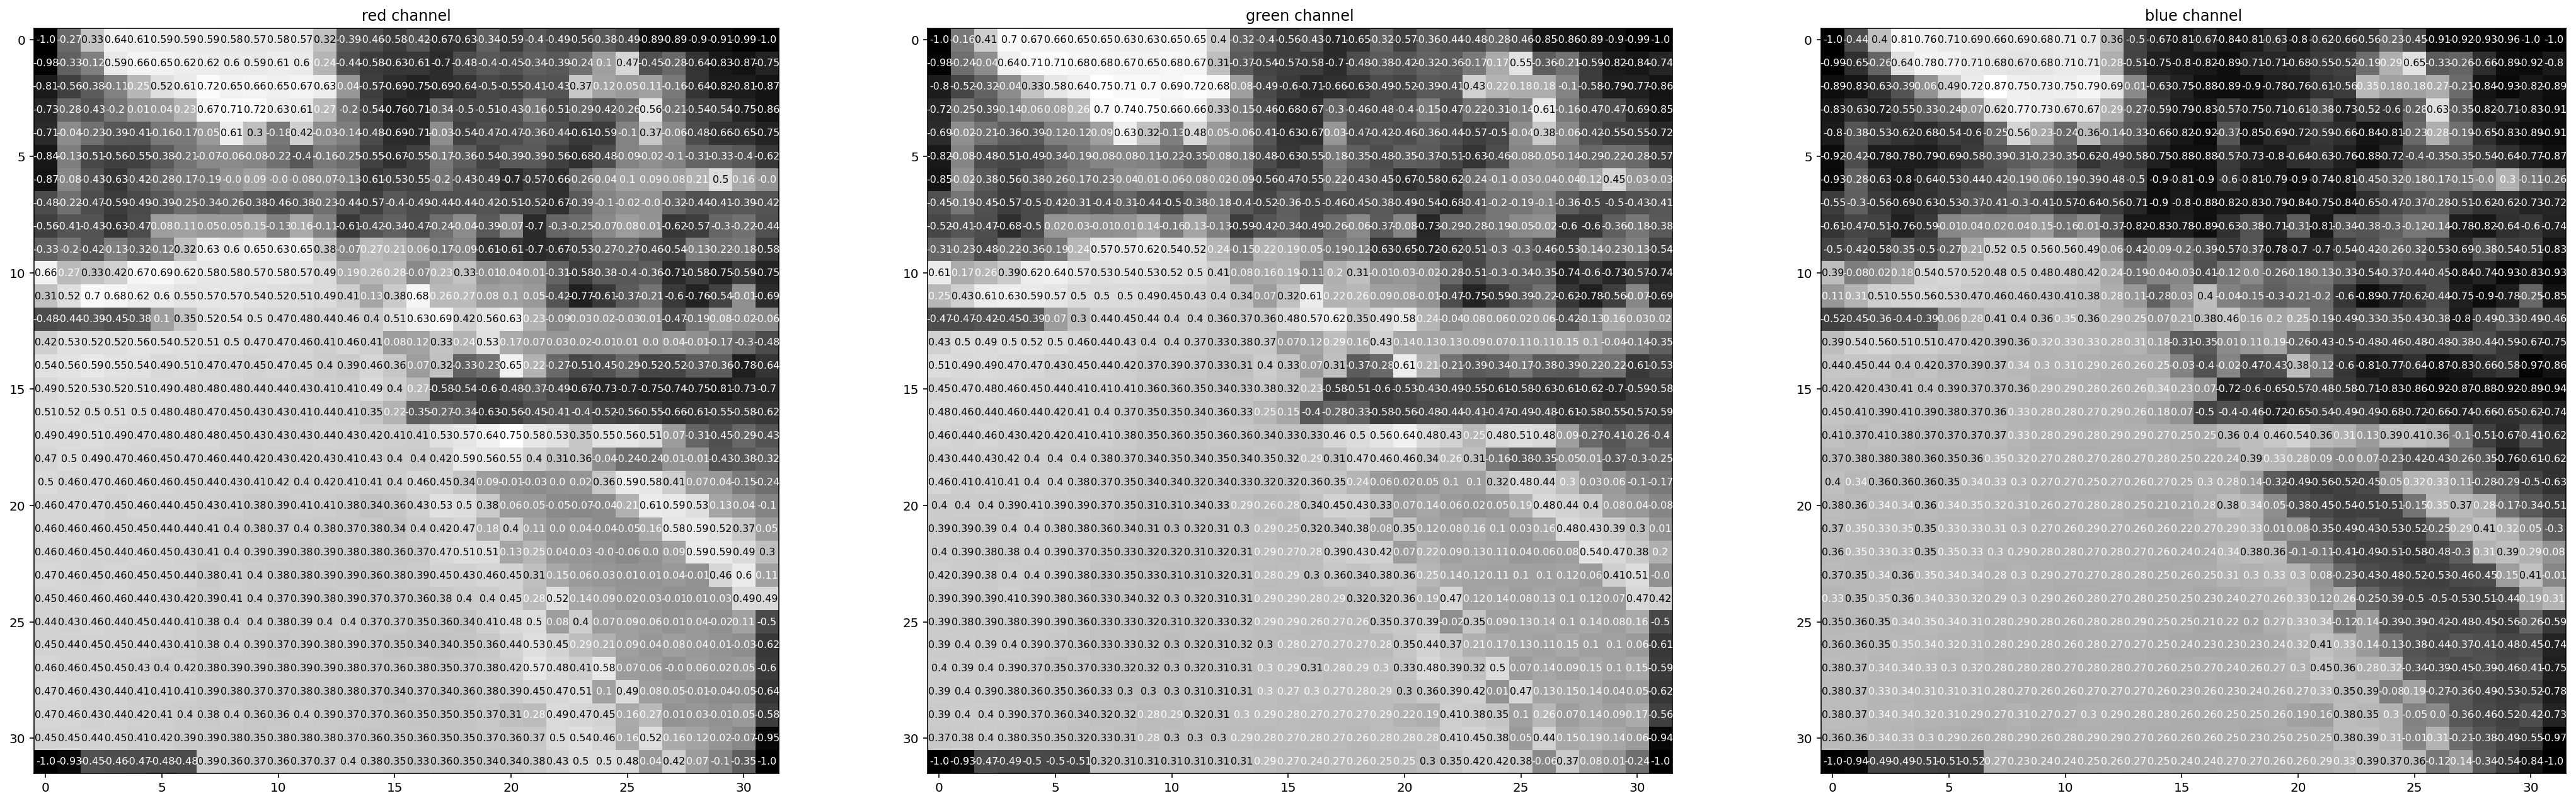

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the pre-trained VGG16 model from torchvision.models and print the architecture
model = models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
# Freeze parameters so we don't backprop through them --> this speeds up the training time
for param in model.parameters():
    param.requires_grad = False

# We need to create a new classifier because we only have 5 output features
model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 1000), 
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(1000, 5))

# Defining our loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)

# Move model to device
model.to(device);

Train the Model

In [ ]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)    

    # validate the model 
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training and validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.674181 	Validation Loss: 1.154542
Validation loss decreased (inf --> 1.154542).  Saving model ...
Epoch: 2 	Training Loss: 1.218987 	Validation Loss: 1.124335
Validation loss decreased (1.154542 --> 1.124335).  Saving model ...
Epoch: 3 	Training Loss: 1.144442 	Validation Loss: 1.090454
Validation loss decreased (1.124335 --> 1.090454).  Saving model ...
Epoch: 4 	Training Loss: 1.126763 	Validation Loss: 1.166396
Epoch: 5 	Training Loss: 1.094144 	Validation Loss: 1.034641
Validation loss decreased (1.090454 --> 1.034641).  Saving model ...


Load Model with the Lowest Validation Loss

In [ ]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

Test the Model

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

model.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to ground truth
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device == "cuda" else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item() 
        class_total[label] += 1 

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.051842

Test Accuracy of Bicycle: 78% (65/83)
Test Accuracy of Bridge: 68% (35/51)
Test Accuracy of   Bus: 63% (69/108)
Test Accuracy of   Car: 30% (31/102)
Test Accuracy of Traffic Light: 76% (58/76)

Test Accuracy (Overall): 61% (258/420)


Visualize Test Sample Results

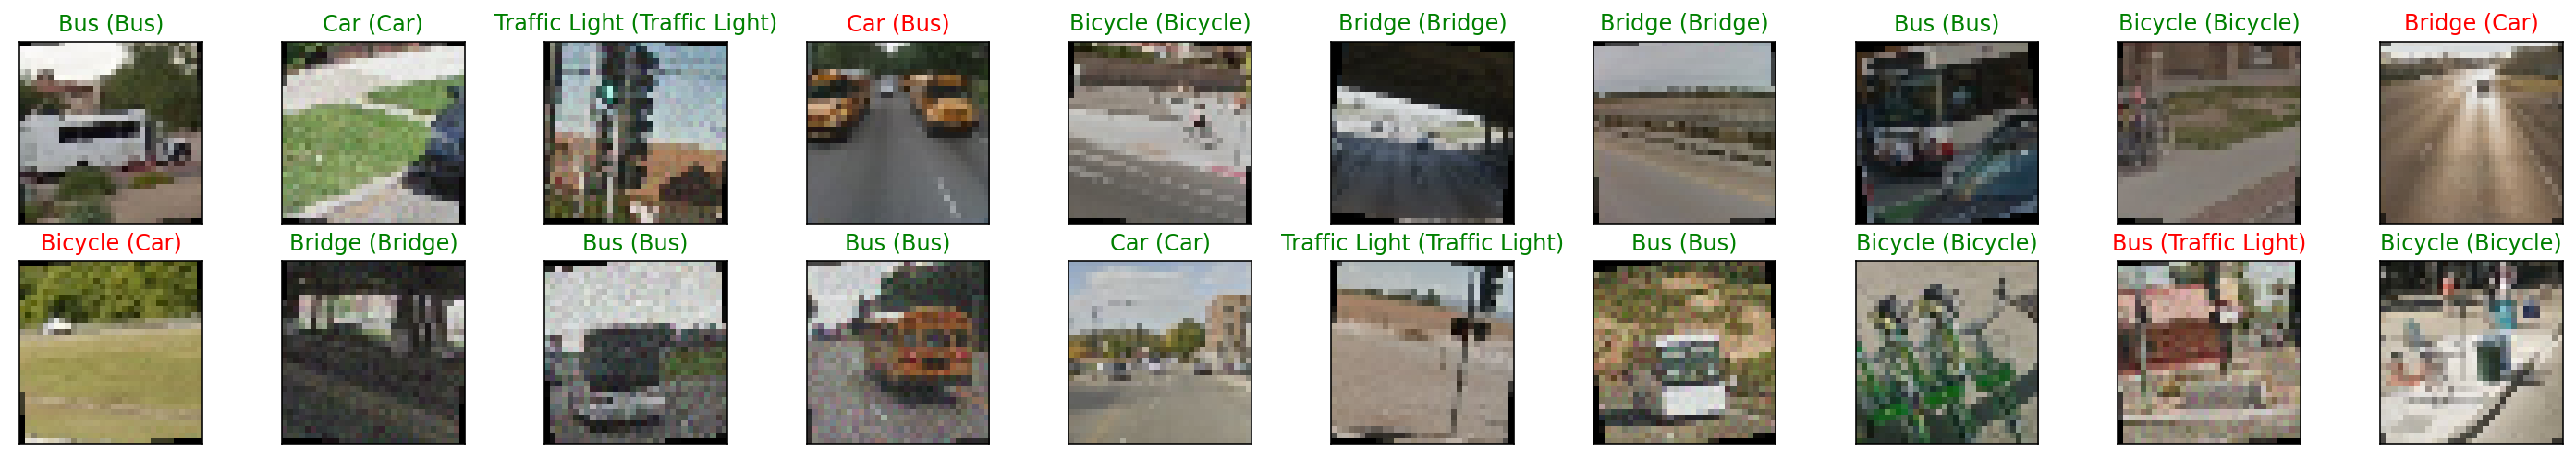

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not device == "cuda" else np.squeeze(preds_tensor.cpu().numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))